# References
- https://www.tensorflow.org/recommenders/examples/basic_retrieval
- https://www.tensorflow.org/recommenders/examples/basic_ranking

# Initial Imports

In [1]:
%pip install -q tensorflow-recommenders


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [360]:
from typing import Dict, Text

import pandas as pd
import numpy as np
import tensorflow as tf
import random

import tensorflow_recommenders as tfrs

import matplotlib.pyplot as plt
import itertools
import seaborn as sns

# Loading Data

In [2]:
events_csv_path = '../events.csv'
ratings_csv_path = '../ratings.csv'
key='9aadb790'
user_count=1000
generate_count=1000
event_count=400

ratings_df = pd.read_csv(f"https://my.api.mockaroo.com/rating.json?key={key}&count={generate_count}&user_id={user_count}&event_id={event_count}")

# drop duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        ratings_df.drop(index=row, inplace=True)

ratings_df.reset_index(drop=True, inplace=True)

# check for duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        print(row)


ratings_df.to_csv(ratings_csv_path, sep=',', encoding='utf-8', index=False)
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

In [3]:
events_df = pd.read_csv(events_csv_path)

non_numeric_cols = events_df.select_dtypes(exclude=['int64', 'float64', 'string']).columns
events_df[non_numeric_cols] = events_df[non_numeric_cols].astype(str)
events_df['interested'] = events_df['interested'].fillna(0).astype(int)

events = tf.data.Dataset.from_tensor_slices(dict(events_df))

In [361]:
print(ratings_df.info(verbose=True))
print(events_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      1000 non-null   int64
 1   user_rating  1000 non-null   int64
 2   event_id     1000 non-null   int64
dtypes: int64(3)
memory usage: 23.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           400 non-null    int64 
 1   date         400 non-null    object
 2   event_name   400 non-null    object
 3   location     400 non-null    object
 4   description  400 non-null    object
 5   tags         400 non-null    object
 6   interested   400 non-null    int32 
dtypes: int32(1), int64(1), object(5)
memory usage: 20.4+ KB
None


In [362]:
ratings_df.head(3)

,user_id,user_rating,event_id
0,109,5,300
1,568,3,233
2,263,5,175


In [363]:
events_df.head(3)

,id,date,event_name,location,description,tags,interested
0,1,"Wed, 24 - Fri, 26 May 2023",Tyre & Rubber Indonesia,Jakarta,The Tyre & Rubber Indonesia is the only dedica...,"Tradeshow, Auto & Automotive, Rubber & Tyres",304
1,2,"Wed, 24 - Fri, 26 May 2023","Indonesia International Construction, Infrastr...",Jakarta,Con-Mine â€“ GET your ultimate business chance...,"Tradeshow, Building & Construction",102
2,3,"Sun, 11 - Wed, 14 Jun 2023",ICM Triennial Congress,Bali,It will be six years since our last in-person ...,"Conference, Medical & Pharma, Investment",35


In [364]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      1000 non-null   int64 
 1   user_rating  1000 non-null   int64 
 2   event_id     1000 non-null   int64 
 3   id           1000 non-null   int64 
 4   date         1000 non-null   object
 5   event_name   1000 non-null   object
 6   location     1000 non-null   object
 7   description  1000 non-null   object
 8   tags         1000 non-null   object
 9   interested   1000 non-null   int32 
dtypes: int32(1), int64(4), object(5)
memory usage: 74.3+ KB


In [365]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
location_df = pd.get_dummies(processed_df['location'])
location_df.rename(columns=lambda x: f'location_{x}'.lower().replace(' ', '_'), inplace=True)
processed_df = processed_df.drop(['id','date','description','interested','location','tags'],axis=1)
processed_df = pd.concat([processed_df, location_df],axis=1)
processed_df.head(3)

,user_id,user_rating,event_id,event_name,location_andir,location_bali,location_balikpapan,location_balikpapan_kota,location_banda_aceh,location_bandung,...,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_tegalsari,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
0,109,5,300,International Conference on High Voltage Engin...,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,894,2,300,International Conference on High Voltage Engin...,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,782,1,300,International Conference on High Voltage Engin...,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [366]:
ratings = tf.data.Dataset.from_tensor_slices(dict(processed_df))
events = tf.data.Dataset.from_tensor_slices(dict(processed_df)).map(lambda x: x["event_id"])

In [367]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
n = tf.data.experimental.cardinality(shuffled)

train = shuffled.take(int(n*4/5))
test = shuffled.skip(int(n*4/5)).take(int(n*1/5))
cached_train = train.shuffle(100_000).batch(8192)
cached_test = test.batch(4096)

In [368]:
event_names = events.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_event_ids = np.unique(np.concatenate(list(event_names)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print(unique_event_ids[:5])
print(unique_user_ids[:5])

[1 2 3 4 5]
[1 2 3 4 7]


# Creating Models

## Retrieval Model

In [381]:
class RetrievalModel(tfrs.Model):
  embedding_dimension = 32
  def __init__(self):
    super().__init__()
    self.event_model: tf.keras.Model = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(vocabulary=unique_event_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_event_ids) + 1, self.embedding_dimension)
    ])
    self.user_model: tf.keras.Model = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, self.embedding_dimension)
    ])

    self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
      metrics = tfrs.metrics.FactorizedTopK(
        candidates=events.batch(128).map(self.event_model)
      ))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    positive_event_embeddings = self.event_model(features["event_id"])

    # parameter: query embedding, candidate embedding.
    return self.task(user_embeddings, positive_event_embeddings)

## Ranking Model

In [392]:
class RankingModel(tf.keras.Model):
  embedding_dimension = 32
  def __init__(self):
    super().__init__()
    self.user_embeddings = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, self.embedding_dimension)
    ])
    self.event_embeddings = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(vocabulary=unique_event_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_event_ids) + 1, self.embedding_dimension)
    ])

    self.ratings = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)
    ])
  
  def call(self, inputs):
    user_id, event_id = inputs

    user_embedding = self.user_embeddings(user_id)
    event_embedding = self.event_embeddings(event_id)

    # predict rating that the user would give to the event
    return self.ratings(tf.concat([user_embedding, event_embedding], axis=1))

class EventModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.Accuracy(),
        ],
    )

  # Call what model to use when making prediction
  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["event_id"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # pop rating as the target label
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

# Model Fitting, Evaluating, Predicting

## Retrieval Model

### Fitting and evaluating

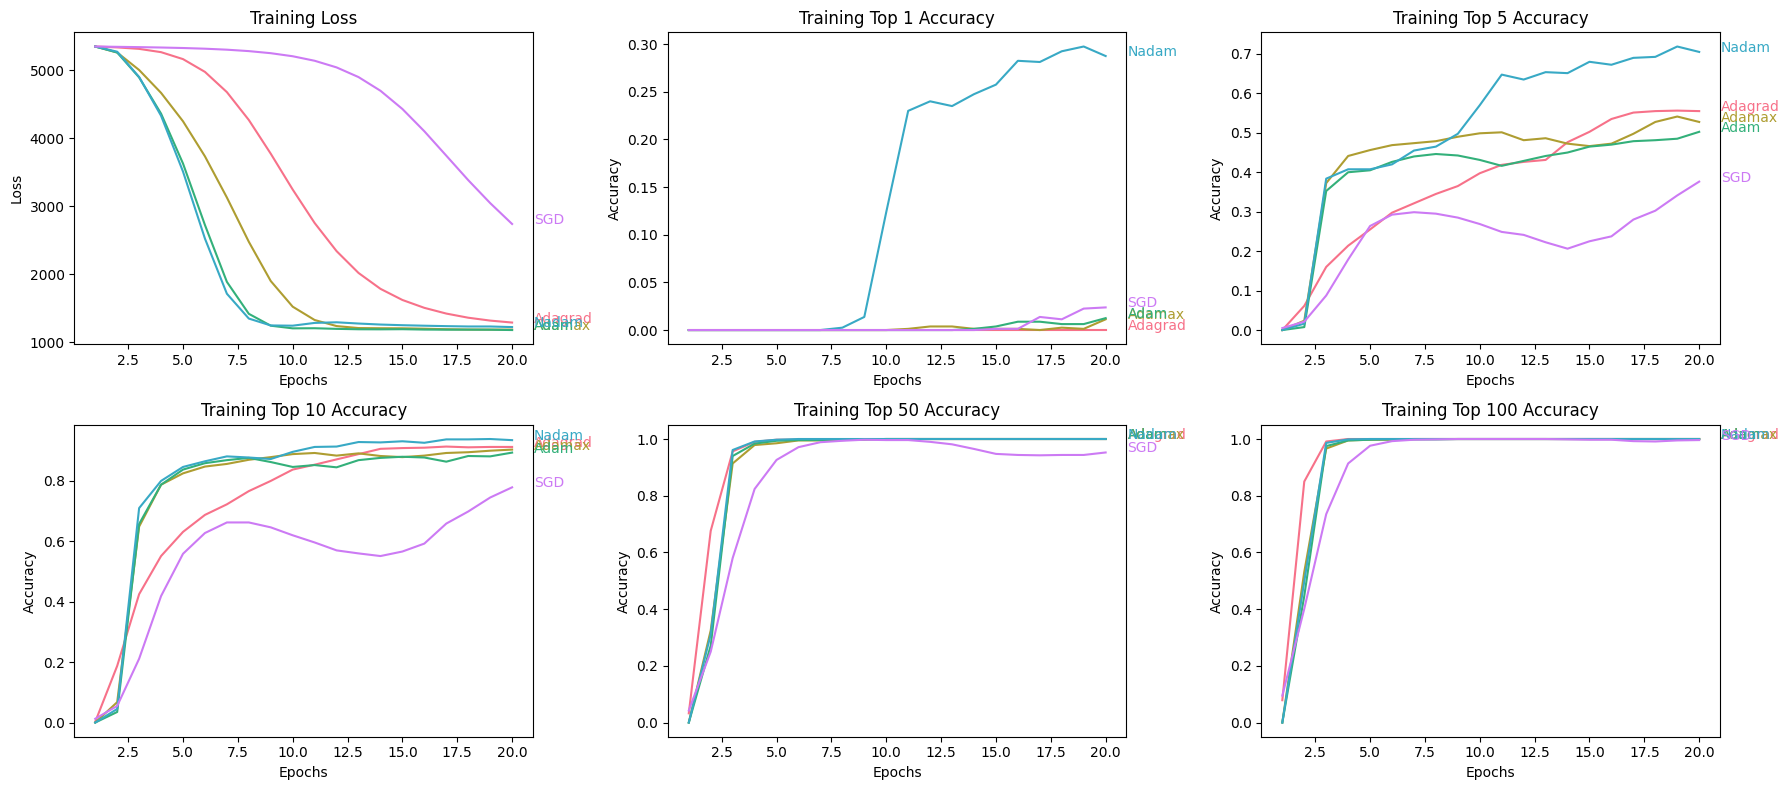

In [373]:
optimizers = [
        tf.keras.optimizers.Adagrad,
        tf.keras.optimizers.Adamax,
        tf.keras.optimizers.Adam,
        tf.keras.optimizers.Nadam,
        tf.keras.optimizers.SGD,
    ]
colors = sns.color_palette('husl', len(optimizers))
plt.figure(figsize=(6*3, 4*2))
for (optimizer, color) in zip(optimizers, colors):
    retrieval_model = RetrievalModel()
    retrieval_model.compile(optimizer=optimizer(learning_rate=0.1))

    history = retrieval_model.fit(cached_train, validation_data=cached_test, epochs=20, verbose=0)

    # Retrieve the training metrics and validation metrics
    train_loss = history.history['loss']
    train_top_1 = history.history['factorized_top_k/top_1_categorical_accuracy']
    train_top_5 = history.history['factorized_top_k/top_5_categorical_accuracy']
    train_top_10 = history.history['factorized_top_k/top_10_categorical_accuracy']
    train_top_50 = history.history['factorized_top_k/top_50_categorical_accuracy']
    train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']

    # Plotting the metrics
    epochs = range(1, len(train_loss) + 1)

    # Plotting the loss metrics
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_loss, color=color)
    plt.title(f'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_loss[-1]), xytext=(epochs[-1] + 1, train_loss[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 2)
    plt.plot(epochs, train_top_1, color=color)
    plt.title(f'Training Top 1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_1[-1]), xytext=(epochs[-1] + 1, train_top_1[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_top_5, color=color)
    plt.title(f'Training Top 5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_5[-1]), xytext=(epochs[-1] + 1, train_top_5[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 4)
    plt.plot(epochs, train_top_10, color=color)
    plt.title(f'Training Top 10 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_10[-1]), xytext=(epochs[-1] + 1, train_top_10[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 5)
    plt.plot(epochs, train_top_50, color=color)
    plt.title(f'Training Top 50 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_50[-1]), xytext=(epochs[-1] + 1, train_top_50[-1]), color=color)

    # Plotting the accuracy metrics
    plt.subplot(2, 3, 6)
    plt.plot(epochs, train_top_100, color=color)
    plt.title(f'Training Top 100 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.annotate(optimizer().name, xy=(epochs[-1], train_top_100[-1]), xytext=(epochs[-1] + 1, train_top_100[-1]), color=color)
    # Display the plot

    plt.tight_layout()
plt.show()

### We pick Nadam as one of the better achieving models.

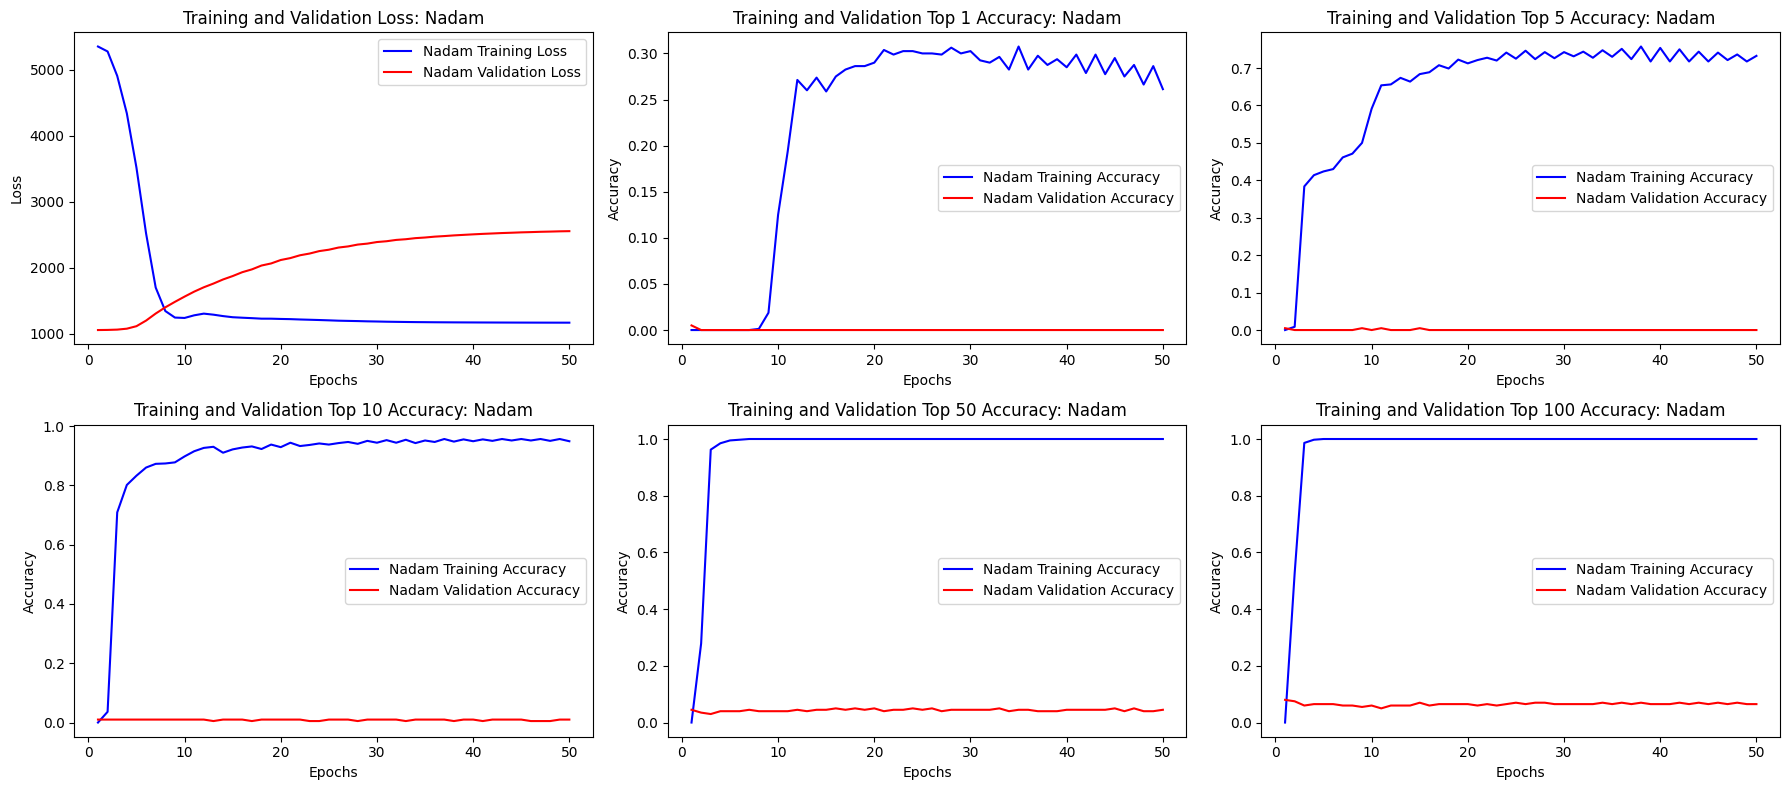

In [386]:
optimizer = tf.keras.optimizers.Nadam

plt.figure(figsize=(6*3, 4*2))

retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=optimizer(learning_rate=0.1))

history = retrieval_model.fit(cached_train, validation_data=cached_test, epochs=50, verbose=0)

# Retrieve the training metrics and validation metrics
train_loss = history.history['loss']
train_top_1 = history.history['factorized_top_k/top_1_categorical_accuracy']
train_top_5 = history.history['factorized_top_k/top_5_categorical_accuracy']
train_top_10 = history.history['factorized_top_k/top_10_categorical_accuracy']
train_top_50 = history.history['factorized_top_k/top_50_categorical_accuracy']
train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']
val_loss    = history.history['val_loss']
val_top_1   = history.history['val_factorized_top_k/top_1_categorical_accuracy']
val_top_5   = history.history['val_factorized_top_k/top_5_categorical_accuracy']
val_top_10  = history.history['val_factorized_top_k/top_10_categorical_accuracy']
val_top_50  = history.history['val_factorized_top_k/top_50_categorical_accuracy']
val_top_100 = history.history['val_factorized_top_k/top_100_categorical_accuracy']

# Plotting the metrics
epochs = range(1, len(train_loss) + 1)

# Plotting the loss metrics
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'b', label=f'{optimizer().name} Training Loss')
plt.plot(epochs, val_loss, 'r', label=f'{optimizer().name} Validation Loss')
plt.title(f'Training and Validation Loss: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 2)
plt.plot(epochs, train_top_1, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_1, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 1 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 3)
plt.plot(epochs, train_top_5, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_5, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 5 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 4)
plt.plot(epochs, train_top_10, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_10, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 10 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 5)
plt.plot(epochs, train_top_50, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_50, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 50 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the accuracy metrics
plt.subplot(2, 3, 6)
plt.plot(epochs, train_top_100, 'b', label=f'{optimizer().name} Training Accuracy')
plt.plot(epochs, val_top_100, 'r', label=f'{optimizer().name} Validation Accuracy')
plt.title(f'Training and Validation Top 100 Accuracy: {optimizer().name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [387]:
retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.1))
retrieval_model.fit(cached_train, epochs=20, verbose=0)
retrieval_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 336ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0050 - factorized_top_k/top_50_categorical_accuracy: 0.0300 - factorized_top_k/top_100_categorical_accuracy: 0.1000 - loss: 2064.2759 - regularization_loss: 0.0000e+00 - total_loss: 2064.2759


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.004999999888241291,
 'factorized_top_k/top_50_categorical_accuracy': 0.029999999329447746,
 'factorized_top_k/top_100_categorical_accuracy': 0.10000000149011612,
 'loss': 2064.27587890625,
 'regularization_loss': 0,
 'total_loss': 2064.27587890625}

Why test performance is bad:
- The model is re-recommending some events that the users' already rated. These can crowd out test movies out of top K recommendations.
    - In some cases, re-recommending past things is good.

### Making predictions

Now that we have a retrieval_model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [388]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location_andir,location_bali,location_balikpapan,location_balikpapan_kota,location_banda_aceh,location_bandung,...,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_tegalsari,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
15,495,2,159,Halal Expo Indonesia (HEI),False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Note: make at least one inference before saving model.
This is done to make the model know which type of data it should be receiving.

In [433]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model, k=len(processed_df))
# recommends events out of the entire events dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((events.batch(100), events.batch(100).map(retrieval_model.event_model)))
)

# Get k recommendations. INPUT MUST HAVE AT LEAST K ITEMS
key, titles = index(tf.constant([user_id]))
print(f"Recommendations for user {user_id}: {[str(i.numpy()) for i in titles[0, :]]}")

Recommendations for user 964: ['100', '100', '100', '100', '67', '67', '67', '50', '50', '50', '224', '224', '389', '389', '389', '308', '308', '38', '38', '55', '55', '55', '152', '152', '152', '152', '184', '184', '73', '73', '293', '344', '344', '387', '387', '387', '330', '330', '116', '116', '121', '121', '121', '167', '102', '102', '60', '28', '28', '28', '347', '378', '378', '62', '62', '62', '62', '268', '93', '93', '93', '104', '104', '104', '365', '365', '365', '365', '365', '331', '331', '399', '399', '205', '205', '205', '205', '205', '290', '290', '247', '247', '247', '63', '63', '63', '63', '63', '63', '375', '375', '375', '375', '219', '80', '80', '82', '37', '37', '37', '37', '348', '348', '348', '348', '172', '245', '245', '245', '245', '169', '169', '321', '321', '321', '321', '88', '88', '88', '88', '88', '88', '123', '123', '123', '123', '304', '132', '132', '132', '132', '132', '162', '162', '162', '162', '261', '261', '261', '333', '333', '333', '333', '333', '217

## Ranking Model

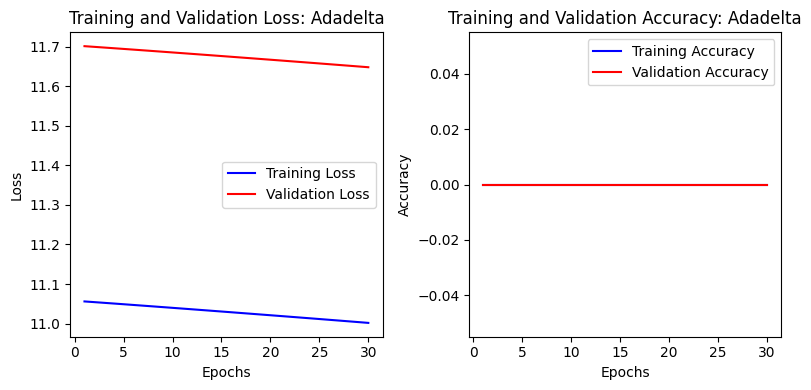

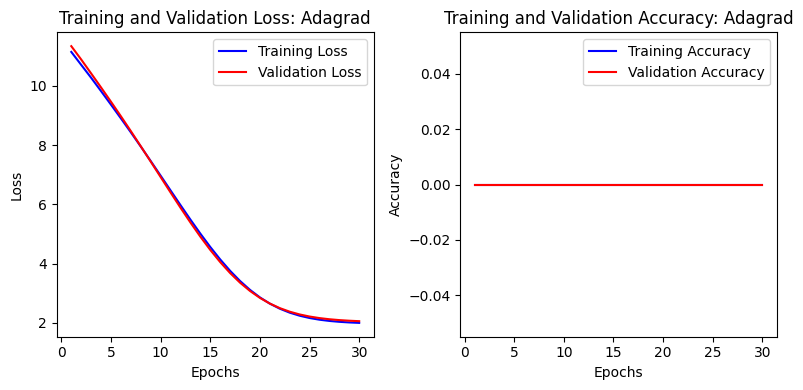

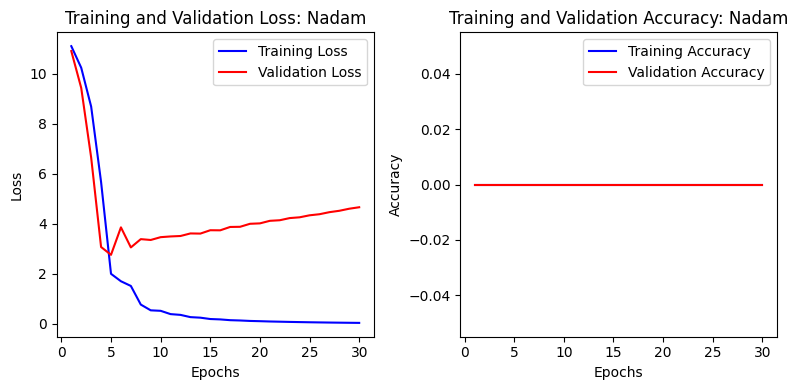

In [393]:
optimizers = [
        tf.keras.optimizers.Adadelta,
        tf.keras.optimizers.Adagrad,
        tf.keras.optimizers.Nadam,
    ]
for optimizer in optimizers:
    ranking_model = EventModel()
    ranking_model.compile(optimizer=optimizer(learning_rate=0.01))
    history = ranking_model.fit(cached_train, validation_data=cached_test, epochs=30, verbose=0)

    # Retrieve the training metrics and validation metrics
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plotting the metrics
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plotting the loss metrics
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss: {optimizer().name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the accuracy metrics
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy: {optimizer().name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

### Choose learning rate

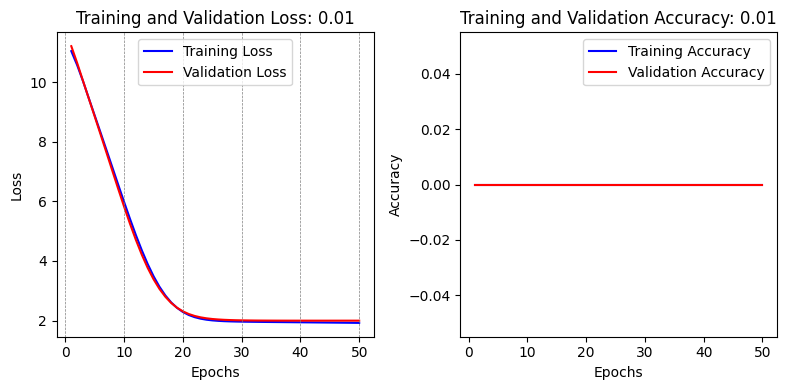

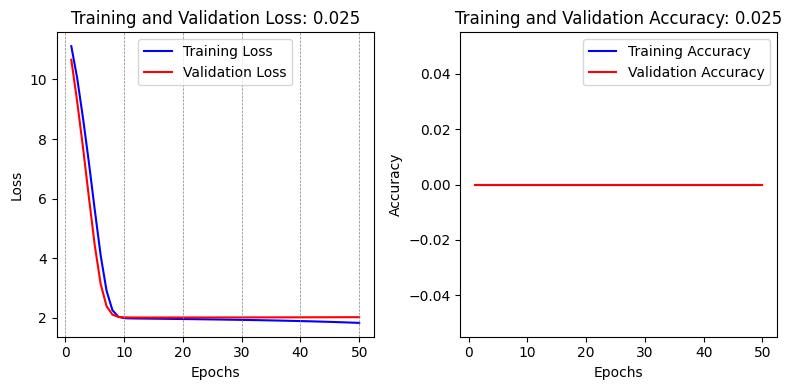

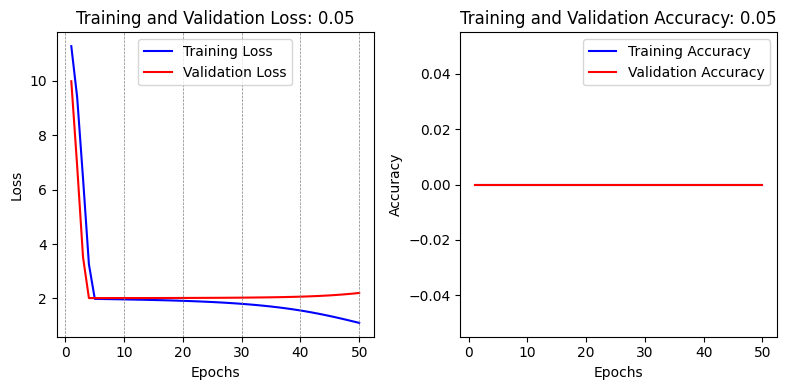

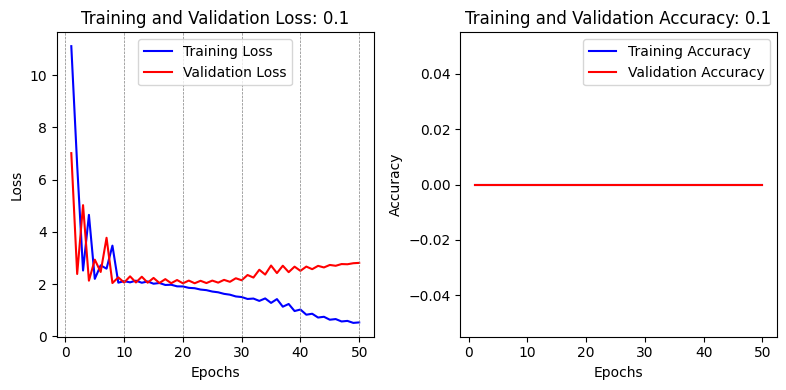

In [405]:
learning_rates = sorted([0.01,0.025,0.05,0.1])
for lr in learning_rates:
    ranking_model = EventModel()
    ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=lr))
    history = ranking_model.fit(cached_train, validation_data=cached_test, epochs=50, verbose=0)

    # Retrieve the training metrics and validation metrics
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plotting the metrics
    epochs = range(1, len(train_loss) + 1)
    lines = ([0] + list(epochs))[::int(len(train_loss)/5)]

    plt.figure(figsize=(12, 4))

    # Plotting the loss metrics
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(lines)
    [plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5) for epoch in lines]
    plt.legend()

    # Plotting the accuracy metrics
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

# Finalize model

In [430]:
lr = 0.025
epochs = 10
ranking_model = EventModel()
ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=lr))
ranking_model.fit(cached_train, validation_data=cached_test, epochs=epochs, verbose=0)
ranking_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 34ms/step - root_mean_squared_error: 1.4174 - accuracy: 0.0000e+00 - loss: 2.0091 - regularization_loss: 0.0000e+00 - total_loss: 2.0091


{'root_mean_squared_error': 1.4174363613128662,
 'accuracy': 0.0,
 'loss': 2.0091259479522705,
 'regularization_loss': 0,
 'total_loss': 2.0091259479522705}

In [408]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location_andir,location_bali,location_balikpapan,location_balikpapan_kota,location_banda_aceh,location_bandung,...,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_tegalsari,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
365,472,5,295,Regional Workshop on the Development and Imple...,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
564,472,2,263,Deep and Extreme Indonesia,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [414]:
test_ratings = {}
test_event_ids = np.unique(processed_df['event_id'])
for event_id in test_event_ids:
  test_ratings[event_id] = ranking_model({
      "user_id": np.array([user_id]),
      "event_id": np.array([event_id])
  })
[('event_id','score')]+[(i,float(j)) for (i,j) in sorted(test_ratings.items(), key=lambda x: x[1][0][0], reverse=True)]

[('event_id', 'score'),
 (361, 2.894169330596924),
 (15, 2.8937807083129883),
 (37, 2.8910841941833496),
 (154, 2.8906497955322266),
 (372, 2.889474391937256),
 (225, 2.887454032897949),
 (34, 2.8849573135375977),
 (197, 2.8838939666748047),
 (343, 2.883086681365967),
 (339, 2.8827099800109863),
 (243, 2.8825435638427734),
 (344, 2.8825225830078125),
 (200, 2.8822379112243652),
 (226, 2.881845474243164),
 (395, 2.8813343048095703),
 (159, 2.879741668701172),
 (127, 2.8788022994995117),
 (299, 2.878657341003418),
 (141, 2.8780951499938965),
 (354, 2.8779735565185547),
 (160, 2.8776960372924805),
 (76, 2.876509189605713),
 (231, 2.8765077590942383),
 (184, 2.8764915466308594),
 (340, 2.8763084411621094),
 (262, 2.8754701614379883),
 (121, 2.875349521636963),
 (182, 2.8741707801818848),
 (187, 2.873635768890381),
 (253, 2.8735756874084473),
 (139, 2.8732223510742188),
 (204, 2.8724660873413086),
 (102, 2.871896266937256),
 (352, 2.870692253112793),
 (295, 2.8704042434692383),
 (27, 2.8701

# Model Serving

## Retrieval Model

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In [415]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,location_andir,location_bali,location_balikpapan,location_balikpapan_kota,location_banda_aceh,location_bandung,...,location_sukasari,location_sumbersari,location_surabaya,location_surakarta,location_tangerang,location_tegalsari,location_ubud,location_west_denpasar,location_west_semarang,location_yogyakarta
423,964,4,67,International Conference on International Secu...,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
542,964,3,100,Asia Pacific HR Forum,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [435]:
# path = os.path.join(tmp, "model")
path = "./retrieval_model"

# Save the index.
tf.saved_model.save(index, path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a user id in, get top predicted event titles back.
scores, titles = loaded([user_id])

INFO:tensorflow:Assets written to: ./retrieval_model\assets


INFO:tensorflow:Assets written to: ./retrieval_model\assets


<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[ 1.66571636e+01,  1.66571636e+01,  1.66571636e+01,
         1.66571636e+01,  1.57551765e+01,  1.57551765e+01,
         1.57551765e+01,  8.28481007e+00,  8.28481007e+00,
         8.28481007e+00,  8.17915535e+00,  8.17915535e+00,
         6.68535662e+00,  6.68535662e+00,  6.68535662e+00,
         6.51703596e+00,  6.51703596e+00,  6.35711241e+00,
         6.35711241e+00,  6.27751017e+00,  6.27751017e+00,
         6.27751017e+00,  6.26422024e+00,  6.26422024e+00,
         6.26422024e+00,  6.26422024e+00,  6.16663742e+00,
         6.16663742e+00,  6.03766203e+00,  6.03766203e+00,
         6.03292751e+00,  5.84655809e+00,  5.84655809e+00,
         5.63870621e+00,  5.63870621e+00,  5.63870621e+00,
         5.50965405e+00,  5.50965405e+00,  5.24067974e+00,
         5.24067974e+00,  5.07719088e+00,  5.07719088e+00,
         5.07719088e+00,  4.95108032e+00,  4.89699697e+00,
         4.89699697e+00,  4.76551580e+00,  4.71696281e+00,
     

## Ranking Model

In [417]:
path = "./ranking_model"
tf.saved_model.save(ranking_model, path)
loaded = tf.saved_model.load(path)

test_ratings = {}
test_event_ids = [random.randint(1,event_count+1) for i in range(1000)]
for event_id in test_event_ids:
  test_ratings[event_id] = loaded.ranking_model((
    tf.constant([user_id], dtype=tf.int64),
    tf.constant([event_id], dtype=tf.int64)
    ))

print("Ratings Desc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1][0][0], reverse=True),10):
  title = id
  print(f"{title}: {score[0][0]}")

print()

print("Ratings Asc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1][0][0]),10):
  title = id
  print(f"{title}: {score[0][0]}")

INFO:tensorflow:Assets written to: ./ranking_model\assets


INFO:tensorflow:Assets written to: ./ranking_model\assets


Ratings Desc:
15: 2.939126968383789
361: 2.938340187072754
226: 2.938063621520996
34: 2.9297471046447754
154: 2.929004192352295
372: 2.9274706840515137
182: 2.9273834228515625
344: 2.926908016204834
37: 2.9257235527038574
184: 2.925581932067871

Ratings Asc:
171: 2.811337947845459
210: 2.830373764038086
238: 2.838718891143799
307: 2.8402814865112305
88: 2.840365409851074
58: 2.8404417037963867
237: 2.843297004699707
11: 2.8440279960632324
367: 2.845780372619629
293: 2.846839427947998
